# Imports

## Import libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from collections import deque
import itertools
import time
import random
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import Data and Processing

In [15]:
data = pd.read_csv('input.csv')
df = data.copy()
# Remove the rows has all zero in those columns 
df = df[~((data['tweet_count'] == 0) & 
            (data['polarity'] == 0) & 
            (data['subjectivity'] == 0) & 
            (data['sentiment'] == 0))]

df = df.set_index('Date').sort_index()
df

,Volume,Price,tweet_count,polarity,subjectivity,sentiment,Elon
Date,,,,,,,
2021-02-05,58598066402,38144.308594,1249.0,0.080351,0.229094,0.200961,0.0
2021-02-06,71326033653,39266.011719,2399.0,0.067151,0.201643,0.180075,0.0
2021-02-07,65500641143,38903.441406,2263.0,0.091361,0.235883,0.223155,1.0
2021-02-08,101467222687,46196.464844,4547.0,0.081043,0.232058,0.248516,1.0
2021-02-09,91809846886,46481.105469,3371.0,0.079506,0.233243,0.249184,0.0
...,...,...,...,...,...,...,...
2022-12-27,15748580239,16717.173828,15997.0,0.086697,0.267919,0.242921,0.0
2023-01-06,14413662913,16951.968750,3374.0,0.063222,0.220758,0.185833,0.0
2023-01-07,7714767174,16955.078125,19056.0,0.077546,0.251754,0.229167,0.0


In [5]:
def processing(process_df, mem_his_days, pre_days):  
    
    # set label
    process_df['label'] = process_df['Price'].shift(-pre_days)

    scaler = StandardScaler()
    sca_X = scaler.fit_transform(process_df.iloc[:,:-1])
    
    deq = deque(maxlen=mem_his_days)

    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq) == mem_his_days:
            X.append(list(deq))

    X_lately = X[-pre_days:]
    X = X[:-pre_days]
    y=df['label'].values[mem_his_days-1:-pre_days]
    X = np.array(X)
    y = np.array(y)
    return X,y, X_lately

# LSTM Modelling

In [6]:
def df_to_model(combination_df):
    results, y_pred_list, y_test_list, train_loss, val_loss, train_mape, val_mape = [], [], [], [], [], [], []

    for index, row in combination_df.iterrows():
        pre_days = row['pre_days']
        mem_days = row['mem_days']
        lstm_layers = row['lstm_layers']
        dense_layers = row['dense_layers']
        units = row['units']
        dropout = row['dropout']
        batch_size = row['batch_size']
        optimizer = row['optimizer']
        learning_rate = row['learning_rate']
        
        print(f"iteration {index+1}/{len(combination_df)}")

        optimizer_instance = None  # Initialize optimizer_instance

        # Create optimizer instance based on the optimizer name
        if optimizer == 'Adam':
            optimizer_instance = Adam(learning_rate=learning_rate)
        elif optimizer == 'RMSprop':
            optimizer_instance = RMSprop(learning_rate=learning_rate)
        elif optimizer == 'Adamax':
            optimizer_instance = Adamax(learning_rate=learning_rate)

        # Your processing and model training code here
        X, y, X_lately = processing(df, mem_days, pre_days)
        
        print(f'pre_days: {pre_days}\nmem_days: {mem_days}\nlstm: {lstm_layers}\n' + \
              f'dense: {dense_layers}\nunits: {units}\ndropout: {dropout}\nbatch_size: {batch_size}\n' + \
              f'optimizer: {optimizer}\nlearning_rate: {learning_rate}\n')

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

        set_seed = 2
        np.random.seed(set_seed)
        random.seed(set_seed)
        tf.random.set_seed(set_seed)

        model = Sequential()

        model.add(LSTM(units, input_shape=X.shape[1:], activation='relu', return_sequences=True))
        model.add(Dropout(dropout, seed=set_seed))

        for i in range(lstm_layers):
            model.add(LSTM(units, activation='relu', return_sequences=True))
            model.add(Dropout(dropout, seed=set_seed))

        model.add(LSTM(units, activation='relu'))
        model.add(Dropout(dropout, seed=set_seed))

        for i in range(dense_layers):
            model.add(Dense(units, activation='relu'))
            model.add(Dropout(dropout, seed=set_seed))

        model.add(Dense(1))

        model.compile(optimizer=optimizer_instance,
                      loss='mse',
                      metrics=['mape'])

        start_time = time.time()  # Record start time

        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=150, validation_data=(X_test, y_test), verbose=0)

        min_val_mape_epoch = np.argmin(history.history['val_mape']) + 1  # Adding 1 because epochs start from 1
        min_val_mape = min(history.history['val_mape'])
        last_val_mape = history.history['val_mape'][-1]

        print(f'min_val_mape_epoch: {min_val_mape_epoch}\nmin_val_mape: {min_val_mape}\nlast_val_mape: {last_val_mape}')

        # Calculate the time taken for model training
        end_time = time.time()
        elapsed_time = end_time - start_time
        time_left = elapsed_time*(len(combination_df)-index+1)
        print(f"Time taken: {elapsed_time:.2f} seconds\nTime left: {time_left:.2f} seconds or {(time_left/3600):.1f} hours")

        # Store the results
        y_pred = model.predict(X_test)
        if np.isnan(y_pred).any():
            y_pred[np.isnan(y_pred)] = 0
        print('\n')
        y_pred = y_pred.flatten().tolist()
        y_pred_list.append(y_pred)
        y_test_list.append(y_test)
        
        mse = round(mean_squared_error(y_test, y_pred), 2)
        mae = round(mean_absolute_error(y_test, y_pred), 2)
        rmse = round(mean_squared_error(y_test, y_pred, squared = False), 2)
        
        # Append results to the list
        results.append((pre_days, mem_days, lstm_layers, dense_layers, units, dropout, batch_size, optimizer,
                        learning_rate, min_val_mape_epoch, min_val_mape, last_val_mape, rmse, mse, mae))
        
        # Access the loss and MAPE from the history
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']
        training_mape = history.history['mape'] 
        validation_mape = history.history['val_mape'] 

        train_loss.append(training_loss)
        val_loss.append(validation_loss)
        train_mape.append(training_mape)
        val_mape.append(validation_mape)

    return results, y_pred_list, y_test_list, train_loss, val_loss, train_mape, val_mape

## Compute Iteration

In [7]:
# Define hyperparameter values
pre_days = [7, 10]
mem_days = [10, 15]
lstm_layers = [1,2,3]
dense_layers = [1,2,3]
units = [16,32, 64]
dropout = [0, 0.1, 0.2, 0.6]
batch_size = [32, 64, 128]
optimizer = ['Adam', 'RMSprop', 'Adamax']
learning_rate = [0.1, 0.01, 0.001]


hyperparameter_combinations = list(itertools.product(
    pre_days, mem_days, lstm_layers, dense_layers,
    units, dropout, batch_size, optimizer, learning_rate
))

# Define column names for the DataFrame
columns = ['pre_days', 'mem_days', 'lstm_layers', 'dense_layers',
           'units', 'dropout', 'batch_size', 'optimizer', 'learning_rate']

# Create a DataFrame with hyperparameter combinations
model_combinations_df = pd.DataFrame(hyperparameter_combinations, columns=columns)

# Display the DataFrame
model_combinations_df

,pre_days,mem_days,lstm_layers,dense_layers,units,dropout,batch_size,optimizer,learning_rate
0,7,10,1,1,16,0.0,32,Adam,0.100
1,7,10,1,1,16,0.0,32,Adam,0.010
2,7,10,1,1,16,0.0,32,Adam,0.001
3,7,10,1,1,16,0.0,32,RMSprop,0.100
4,7,10,1,1,16,0.0,32,RMSprop,0.010
...,...,...,...,...,...,...,...,...,...
11659,10,15,3,3,64,0.6,128,RMSprop,0.010
11660,10,15,3,3,64,0.6,128,RMSprop,0.001
11661,10,15,3,3,64,0.6,128,Adamax,0.100
11662,10,15,3,3,64,0.6,128,Adamax,0.010


In [63]:
columns = ['pre_days', 'mem_days', 'lstm_layers', 'dense_layers', 'units', 'dropout', 'batch_size',
           'optimizer', 'learning_rate', 'min_val_mape_epoch', 'min_val_mape', 'last_val_mape', 'rmse', 'mse', 'mae']

results, y_pred_list, y_test_list, train_loss, val_loss, train_mape, val_mape = df_to_model(model_combinations_df)

#Create DataFrame
results_df = pd.DataFrame(results, columns=columns)
# Display the DataFrame
results_df

iteration 1/972
pre_days: 10
mem_days: 10
lstm: 2
dense: 1
units: 16
dropout: 0.0
batch_size: 32
optimizer: Adam
learning_rate: 0.1

min_val_mape_epoch: 150
min_val_mape: 99.5718002319336
last_val_mape: 99.5718002319336
Time taken: 42.91 seconds
Time left: 41755.95 seconds or 11.6 hours
1/1 [==============================] - 1s 1s/step


iteration 2/972
pre_days: 10
mem_days: 10
lstm: 2
dense: 1
units: 16
dropout: 0.0
batch_size: 32
optimizer: Adam
learning_rate: 0.01

min_val_mape_epoch: 107
min_val_mape: 5.494278907775879
last_val_mape: 7.318706512451172
Time taken: 45.30 seconds
Time left: 44030.52 seconds or 12.2 hours
1/1 [==============================] - 1s 812ms/step


iteration 3/972
pre_days: 10
mem_days: 10
lstm: 2
dense: 1
units: 16
dropout: 0.0
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 136
min_val_mape: 5.6164093017578125
last_val_mape: 8.167984962463379
Time taken: 43.36 seconds
Time left: 42100.75 seconds or 11.7 hours
1/1 [================

KeyboardInterrupt: 

In [ ]:
# Specify the file path for the Excel file
excel_file_path = 'combinations_results.xlsx'

# Export DataFrame to Excel
results_df.to_excel(excel_file_path, index=False)

print(f"DataFrame exported to {excel_file_path}")

In [64]:
results_df

,pre_days,mem_days,lstm_layers,dense_layers,units,dropout,batch_size,optimizer,learning_rate,min_val_mape_epoch,min_val_mape,last_val_mape,rmse,mse,mae
0,10,10,1,1,16,0.0,32,Adam,0.100,104,8.991359,15.614058,3213.10,1.032403e+07,2635.49
1,10,10,1,1,16,0.0,32,Adam,0.010,29,7.419033,23.914818,5725.88,3.278572e+07,4061.83
2,10,10,1,1,16,0.0,32,Adam,0.001,141,9.119890,11.284969,2453.42,6.019278e+06,1929.19
3,10,10,1,1,16,0.0,32,RMSprop,0.100,36,9.907332,99.715134,17228.65,2.968264e+08,17190.40
4,10,10,1,1,16,0.0,32,RMSprop,0.010,102,4.303420,30.564754,5315.03,2.824959e+07,5175.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,10,10,1,3,64,0.6,128,RMSprop,0.010,61,32.268970,59.324383,10315.50,1.064095e+08,10252.90
968,10,10,1,3,64,0.6,128,RMSprop,0.001,80,15.977552,61.658417,10717.97,1.148748e+08,10654.04
969,10,10,1,3,64,0.6,128,Adamax,0.100,1,22.638731,48.252808,8433.13,7.111772e+07,8354.71
970,10,10,1,3,64,0.6,128,Adamax,0.010,80,9.669168,82.308731,14246.93,2.029751e+08,14201.04


# Plot Validation Graph for Selected Models

In [9]:
file_path = 'combinations_results.xlsx'

# Read the 'selected' sheet into a DataFrame named 'selected'
selected = pd.read_excel(file_path, sheet_name='selected')


In [10]:
selected

,pre_days,mem_days,lstm_layers,dense_layers,units,dropout,batch_size,optimizer,learning_rate,min_val_mape_epoch,min_val_mape,last_val_mape
0,10,15,2,1,32,0.1,32,Adam,0.001,141,3.282043,3.386988
1,7,15,2,1,32,0.1,32,Adam,0.001,37,3.654945,8.986032
2,10,15,1,1,32,0.1,32,Adam,0.001,41,4.424600,6.465674
3,10,15,2,2,32,0.1,32,Adam,0.001,104,3.543058,21.901535
4,10,15,2,1,16,0.1,32,Adam,0.001,55,3.744843,4.171615
5,10,15,2,1,32,0.0,32,Adam,0.001,84,4.571097,5.561349
6,10,15,2,1,32,0.6,32,Adam,0.001,34,3.094323,77.347733
7,10,15,2,1,32,0.1,64,Adam,0.001,123,3.395199,3.640816
8,10,15,2,1,32,0.1,128,Adam,0.001,82,3.691719,11.516736
9,10,15,2,1,32,0.1,32,RMSprop,0.001,140,4.378518,5.312894


In [35]:
def plot_val_graph(selected_df):
    plot_folder = './selected_plots'
    os.makedirs(plot_folder, exist_ok=True)
    results, y_pred_list, y_test_list, train_loss, val_loss, train_mape, val_mape = df_to_model(selected_df)
    for i in range(len(selected_df)):
        fig, axes = plt.subplots(1, 2, figsize=(10, 6))
        
        # Plotting the Loss
        axes[0].plot(train_loss[i], label='Training Loss')
        axes[0].plot(val_loss[i], label='Validation Loss')
        axes[0].set_title('Training and Validation Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
    
        # Plotting the MAPE
        axes[1].plot(train_mape[i], label='Training MAPE')
        axes[1].plot(val_mape[i], label='Validation MAPE')
        axes[1].set_title('Training and Validation MAPE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAPE')
        axes[1].legend()
    
        last_val_mape = results[i][11]
        min_val_mape = results[i][10]
        min_val_mape_epoch = results[i][9]
        pre_days = results[i][0]
        mem_days = results[i][1]
        lstm_layers = results[i][2]
        dense_layers = results[i][3]
        units = results[i][4]
        dropout = results[i][5]
        batch_size = results[i][6]
        optimizer = results[i][7]
        learning_rate = results[i][8]
        
        # Extracting information for the title
        title_info = f"last_mape:{last_val_mape:.2f}_min_mape:{min_val_mape:.2f}_epoch:{min_val_mape_epoch}_pre:{pre_days}_mem:{mem_days}" \
                     f"_lstm:{lstm_layers}_dense:{dense_layers}\nunits:{units}_dropout:{dropout}_batch:{batch_size}_optimizer:{optimizer}" \
                     f"_learning_rate:{learning_rate}"
        
        fig.tight_layout(rect=[0, 0, 1, 0.9])
        fig.suptitle(title_info + '\n\n', fontsize=13)
        
        plot_filename = f'{plot_folder}/plot_of_last_mape_{last_val_mape:.2f}_min_mape_{min_val_mape:.2f}_epoch_{min_val_mape_epoch}' + \
                        f'_pre_{pre_days}_mem_{mem_days}_lstm_{lstm_layers}_dense_{dense_layers}_units_{units}_dropout_{dropout}' + \
                        f'_batch_{batch_size}_optimizer_{optimizer}_learning_rate_{learning_rate}.png'
        fig.savefig(plot_filename)
        plt.close(fig)  # Close the figure to release memory

In [36]:
plot_val_graph(selected)

iteration 1/13
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 141
min_val_mape: 3.282042980194092
last_val_mape: 3.3869876861572266
Time taken: 36.99628472328186 seconds
Time left: 517.947986125946
1/1 [==============================] - 1s 578ms/step



iteration 2/13
pre_days: 7
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 48
min_val_mape: 3.5293781757354736
last_val_mape: 9.269030570983887
Time taken: 39.90852451324463 seconds
Time left: 518.8108186721802
1/1 [==============================] - 1s 590ms/step



iteration 3/13
pre_days: 10
mem_days: 15
lstm: 1
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 41
min_val_mape: 4.424600124359131
last_val_mape: 6.465673923492432
Time taken: 31.939939498901367 seconds
Time left: 383.2792739868164
1/1 [==============

# Plot Price Graph

In [11]:
file_path = 'combinations_results.xlsx'

pre_day_compare = pd.read_excel(file_path, sheet_name='pre_day')
lstm_compare = pd.read_excel(file_path, sheet_name='lstm_layer')
dense_compare = pd.read_excel(file_path, sheet_name='dense_layer')
units_compare = pd.read_excel(file_path, sheet_name='units')
dropout_compare = pd.read_excel(file_path, sheet_name='dropout')
batch_size_compare = pd.read_excel(file_path, sheet_name='batch_size')
optimizer_compare = pd.read_excel(file_path, sheet_name='optimizer')
learning_rate_compare = pd.read_excel(file_path, sheet_name='learning_rate')

In [12]:
def plot_price_graph(compare_df):
    results, y_pred_list, y_test_list, train_loss, val_loss, train_mape, val_mape = df_to_model(compare_df)
    columns = ['pre_days', 'mem_days', 'lstm_layers', 'dense_layers', 'units', 'dropout', 'batch_size',
               'optimizer', 'learning_rate', 'min_val_mape_epoch', 'min_val_mape', 'last_val_mape', 'rmse', 'mse', 'mae']

    # pd.set_option('display.float_format', '{:.2f}'.format)
    results_df = pd.DataFrame(results, columns=columns)
    
    exclude_columns = ['min_val_mape_epoch', 'min_val_mape', 'last_val_mape']

    # Find columns with different values, excluding specified columns
    columns_diff_values = compare_df.drop(columns=exclude_columns).columns[compare_df.drop(columns=exclude_columns).nunique() > 1].to_list()
    diff_values = compare_df[columns_diff_values].values.flatten().tolist()
    
    results_df = results_df.set_index(columns_diff_values)[['last_val_mape', 'rmse', 'mae']]
    print(results_df)
    print('\n\n')

    flat_y_pred = [item for sublist in y_pred_list for item in sublist]
    flat_y_test = [item for sublist in y_test_list for item in sublist]
    
    y_max = round(max(max(flat_y_pred), max(flat_y_test)),-3) + 1000
    y_min = round(min(min(flat_y_pred), min(flat_y_test)), -3) - 1000
    
    color = ['green', 'red', 'purple']
    if len(y_test_list[0]) != len(y_test_list[1]):
        df_time = df.index[-len(y_test_list[0]):]
        plt.figure(figsize=(10, 6))
        plt.plot(df_time, y_test_list[0], color='blue', label='actual price')
        plt.plot(df_time, y_pred_list[0], color='green', label=f'predicted price by {columns_diff_values} {diff_values[0]}')
        plt.plot(df_time, y_pred_list[1][1:], color='red', label=f'predicted price by {columns_diff_values} {diff_values[1]}')
        
    elif columns_diff_values == ['lstm_layers', 'dense_layers', 'units'] :
        df_time = df.index[-len(y_test_list[0]):]
        plt.figure(figsize=(10, 6))
        plt.plot(df_time, y_test_list[0], color='blue', label='actual price')
        for i in range(len(y_test_list)):
            plt.plot(df_time, y_pred_list[i], color=color[i], label=f'predicted price by {diff_values[i]} {columns_diff_values} ')

    else:
        df_time = df.index[-len(y_test_list[0]):]
        plt.figure(figsize=(10, 6))
        plt.plot(df_time, y_test_list[0], color='blue', label='actual price')
        for i in range(len(y_test_list)):
            plt.plot(df_time, y_pred_list[i], color=color[i], label=f'predicted price by {diff_values[i]} {columns_diff_values} ')
    
    plt.grid(color = 'orange', linestyle = '--', linewidth = 0.5)
    #plt.suptitle(f'Plot of Bitcoin Price Prediction with different value of {columns_diff_values}')
    plt.ylabel('Bitcoin Price (USD)')
    plt.xlabel('Date')
    plt.yticks(range(int(y_min), int(y_max), 1000))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    

## Comparing Price Prediction between different pre_days [7, 10]

iteration 1/2
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001




min_val_mape_epoch: 141
min_val_mape: 3.282042980194092
last_val_mape: 3.3869876861572266
Time taken: 16.76 seconds
Time left: 50.28 seconds or 0.0 hours
1/1 [==============================] - 0s 347ms/step


iteration 2/2
pre_days: 7
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 48
min_val_mape: 3.5293781757354736
last_val_mape: 9.269030570983887
Time taken: 16.85 seconds
Time left: 33.69 seconds or 0.0 hours
1/1 [==============================] - 0s 338ms/step


          last_val_mape     rmse      mae
pre_days                                 
10             3.386988   817.64   594.59
7              9.269031  2421.68  1617.40





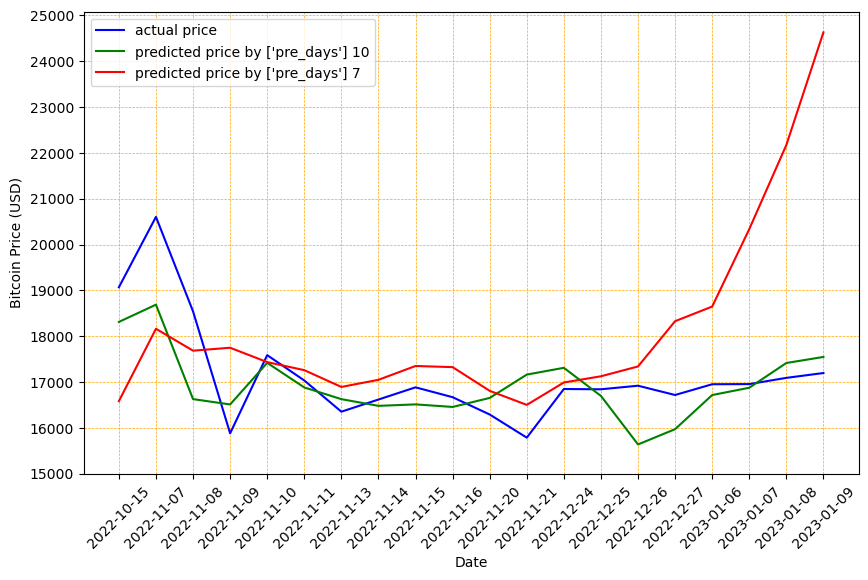

In [13]:
plot_price_graph(pre_day_compare)

## Comparing Price Prediction between different lSTM layers [1, 2]

iteration 1/2
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 141
min_val_mape: 3.282042980194092
last_val_mape: 3.3869876861572266
Time taken: 43.872989654541016 seconds
Time left: 131.61896896362305
1/1 [==============================] - 1s 630ms/step



iteration 2/2
pre_days: 10
mem_days: 15
lstm: 1
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 41
min_val_mape: 4.424600124359131
last_val_mape: 6.465673923492432
Time taken: 33.63019561767578 seconds
Time left: 67.26039123535156
1/1 [==============================] - 0s 457ms/step



             last_val_mape     rmse      mae
lstm_layers                                 
2                 3.386988   817.64   594.59
1                 6.465674  1366.01  1117.10





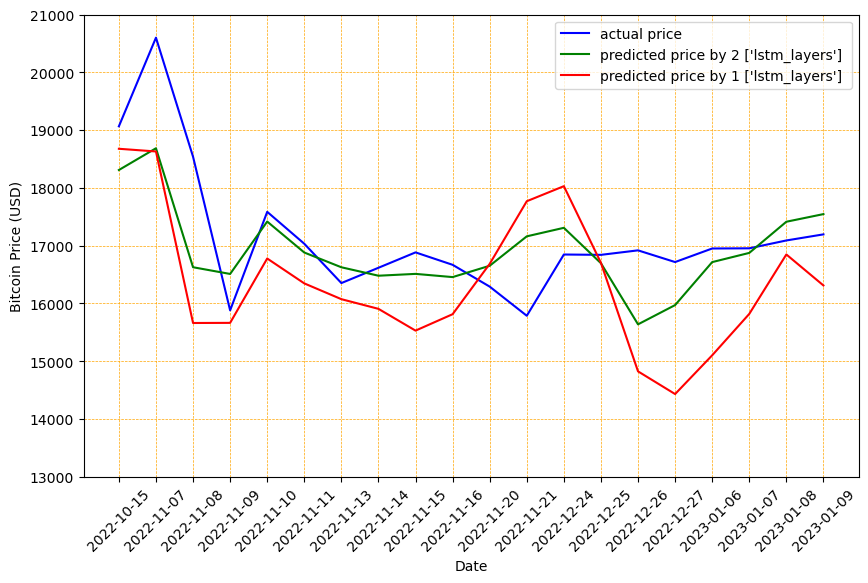

In [108]:
plot_price_graph(lstm_compare)

## Comparing Price Prediction between different dense layers [1, 2]

iteration 1/2
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 141
min_val_mape: 3.282042980194092
last_val_mape: 3.3869876861572266
Time taken: 43.35201048851013 seconds
Time left: 130.0560314655304
1/1 [==============================] - 1s 588ms/step



iteration 2/2
pre_days: 10
mem_days: 15
lstm: 2
dense: 2
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 104
min_val_mape: 3.543058395385742
last_val_mape: 21.901535034179688
Time taken: 45.62814736366272 seconds
Time left: 91.25629472732544
1/1 [==============================] - 1s 590ms/step



              last_val_mape     rmse      mae
dense_layers                                 
1                  3.386988   817.64   594.59
2                 21.901535  3882.72  3786.85





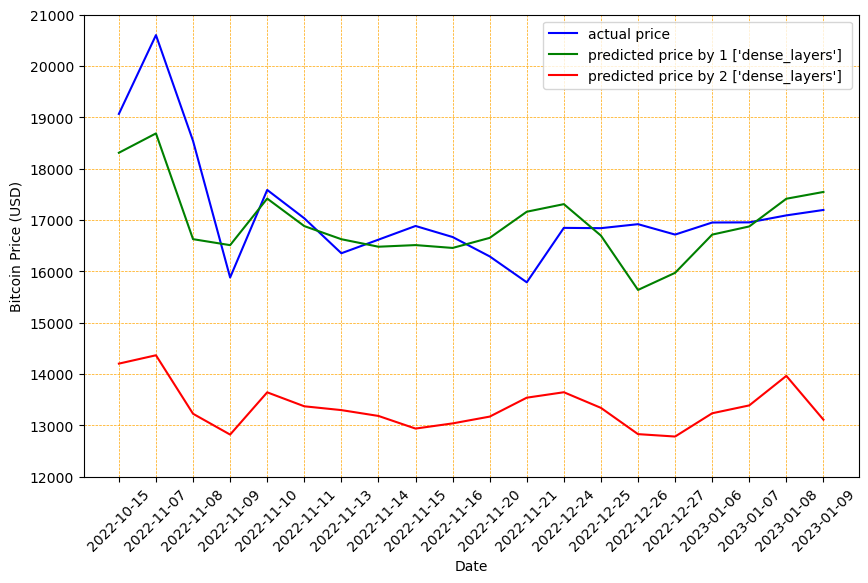

In [112]:
plot_price_graph(dense_compare)

## Comparing Price Prediction between different units [16, 32]

iteration 1/2
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 141
min_val_mape: 3.282042980194092
last_val_mape: 3.3869876861572266
Time taken: 46.06153106689453 seconds
Time left: 138.1845932006836
1/1 [==============================] - 1s 605ms/step



iteration 2/2
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 16
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 55
min_val_mape: 3.7448432445526123
last_val_mape: 4.171614646911621
Time taken: 38.5460090637207 seconds
Time left: 77.0920181274414
1/1 [==============================] - 1s 623ms/step



       last_val_mape    rmse     mae
units                               
32          3.386988  817.64  594.59
16          4.171615  955.15  733.83





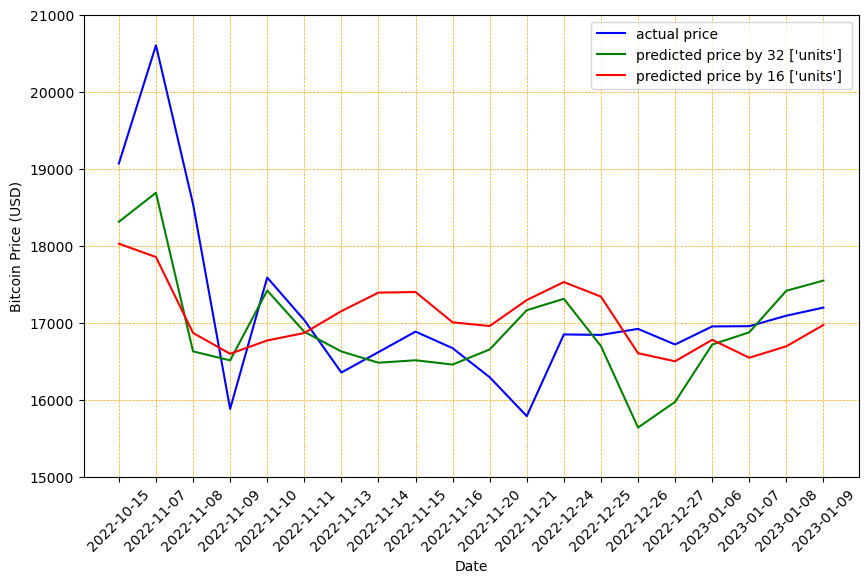

In [113]:
plot_price_graph(units_compare)

## Comparing Price Prediction between different dropout [0, 0.1, 0.6]

iteration 1/3
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 141
min_val_mape: 3.282042980194092
last_val_mape: 3.3869876861572266
Time taken: 44.28520107269287 seconds
Time left: 177.14080429077148
1/1 [==============================] - 1s 640ms/step



iteration 2/3
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.0
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 84
min_val_mape: 4.571096897125244
last_val_mape: 5.561348915100098
Time taken: 35.70984983444214 seconds
Time left: 107.12954950332642
1/1 [==============================] - 1s 567ms/step



iteration 3/3
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.6
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 34
min_val_mape: 3.09432315826416
last_val_mape: 77.34773254394531
Time taken: 41.67954421043396 seconds
Time left: 83.35908842086792
1/1 [================

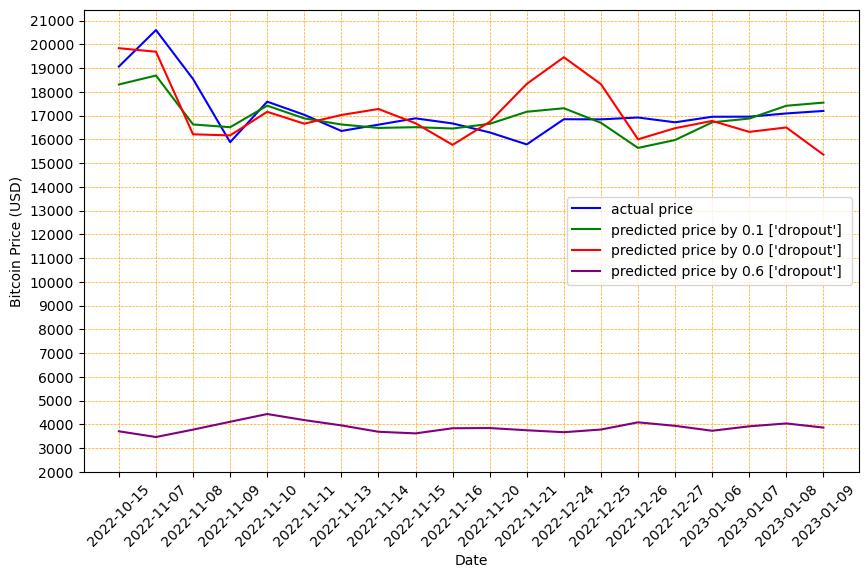

In [114]:
plot_price_graph(dropout_compare)

## Comparing Price Prediction between different batch size [32, 64, 128]

In [ ]:
plot_price_graph(batch_size_compare)

## Comparing Price Prediction between different optimizer [Adam, RMSpopr, Adamax]

iteration 1/3
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 141
min_val_mape: 3.282042980194092
last_val_mape: 3.3869876861572266
Time taken: 41.18392038345337 seconds
Time left: 164.73568153381348
1/1 [==============================] - 1s 757ms/step



iteration 2/3
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: RMSprop
learning_rate: 0.001

min_val_mape_epoch: 140
min_val_mape: 4.3785176277160645
last_val_mape: 5.312893867492676
Time taken: 42.86396908760071 seconds
Time left: 128.59190726280212
1/1 [==============================] - 1s 650ms/step



iteration 3/3
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adamax
learning_rate: 0.001

min_val_mape_epoch: 107
min_val_mape: 5.0323052406311035
last_val_mape: 10.77071475982666
Time taken: 43.949586391448975 seconds
Time left: 87.89917278289795
1/1 [=====

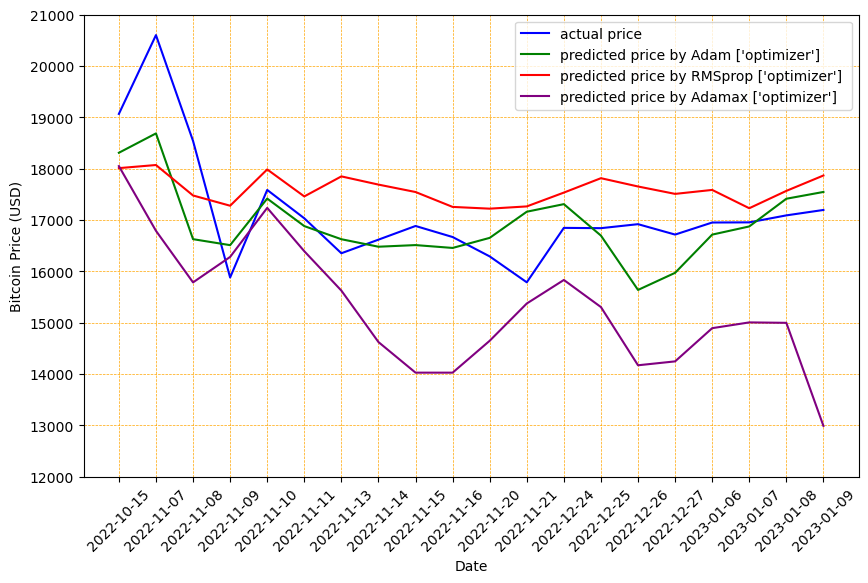

In [110]:
plot_price_graph(optimizer_compare)

## Comparing Price Prediction between different learning rate [0.1, 0.01, 0.001]

iteration 1/3
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 141
min_val_mape: 3.282042980194092
last_val_mape: 3.3869876861572266
Time taken: 45.09566068649292 seconds
Time left: 180.38264274597168
1/1 [==============================] - 1s 746ms/step



iteration 2/3
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.01

min_val_mape_epoch: 76
min_val_mape: 3.5153255462646484
last_val_mape: 4.22639274597168
Time taken: 52.64983582496643 seconds
Time left: 157.9495074748993
1/1 [==============================] - 1s 645ms/step



iteration 3/3
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.1

min_val_mape_epoch: 1
min_val_mape: 100.00148010253906
last_val_mape: 100.00209045410156
Time taken: 40.84638810157776 seconds
Time left: 81.69277620315552
1/1 [==================

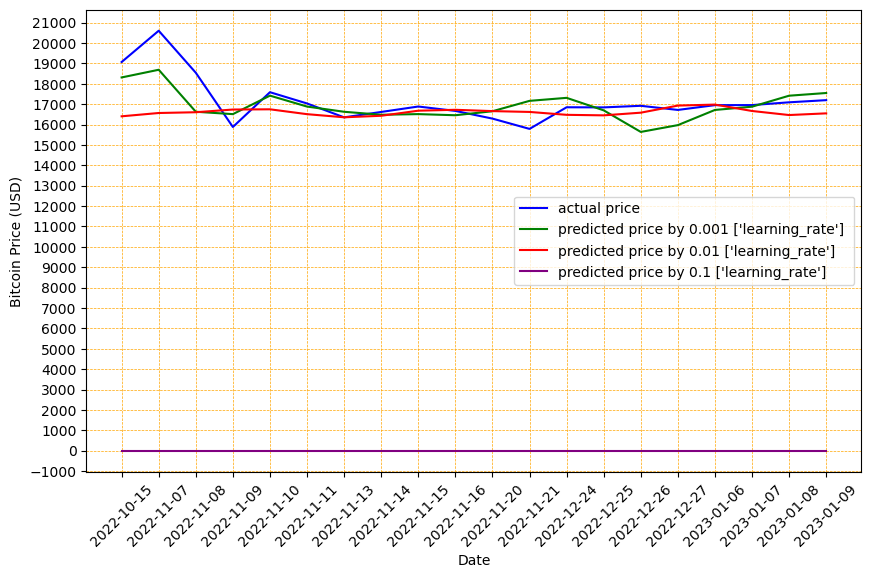

In [111]:
plot_price_graph(learning_rate_compare)

## Plotting best model predicted price against actual price

iteration 1/1
pre_days: 10
mem_days: 15
lstm: 2
dense: 1
units: 32
dropout: 0.1
batch_size: 32
optimizer: Adam
learning_rate: 0.001

min_val_mape_epoch: 141
min_val_mape: 3.282042980194092
last_val_mape: 3.3869876861572266
Time taken: 16.20 seconds
Time left: 32.40 seconds or 0.0 hours
1/1 [==============================] - 0s 361ms/step




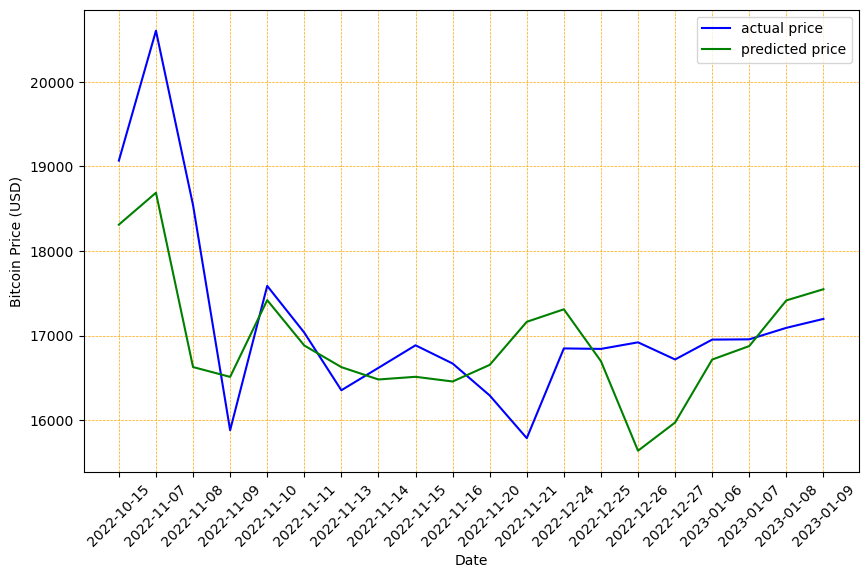

In [14]:
results, y_pred_list, y_test_list, train_loss, val_loss, train_mape, val_mape = df_to_model(selected[0:1])
df_time = df.index[-len(y_test_list[0]):]
plt.figure(figsize=(10, 6))
plt.plot(df_time, y_test_list[0], color='blue', label='actual price')
plt.plot(df_time, y_pred_list[0], color='green', label='predicted price')

plt.grid(color = 'orange', linestyle = '--', linewidth = 0.5)
#plt.suptitle(f'Plot of Bitcoin Price Prediction with different value of {columns_diff_values}')
plt.ylabel('Bitcoin Price (USD)')
plt.xlabel('Date')
#plt.yticks(range(int(y_min), int(y_max), 1000))
plt.xticks(rotation=45)
plt.legend()
plt.show()
    